In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# **ACTIVITY 5: FEATURE EXTRACTION PART 1 OF 3**

## **Image Segmentation**

In [3]:
# Define function that converts rgb image to grayscale
def rgb2gray(rgb):
  return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

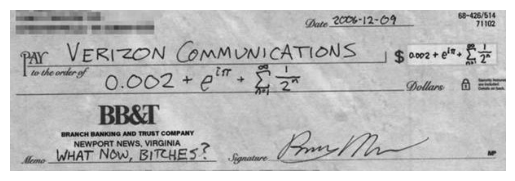

In [4]:
# load in the image of the grayscale check
img = plt.imread('/Users/Amogus/Downloads/roi.jpg')

# Plot
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

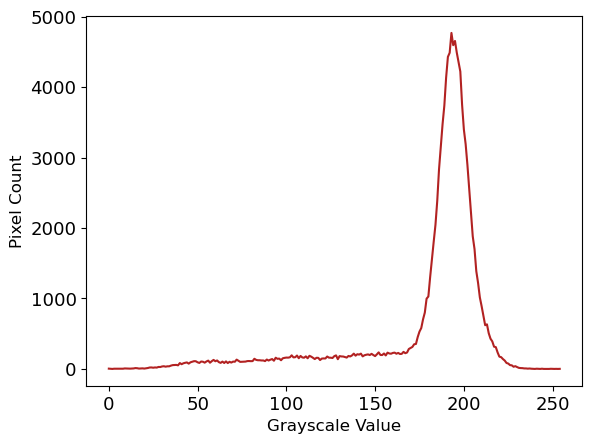

In [5]:
# Returns histogram values in array form and bin edges of the flattened 1D grayscale check array
hist, bin_edges = np.histogram(img.flatten(), bins = 255)

# Plot the grayscale histogram
plt.plot(bin_edges[:-1], hist, color='firebrick')
plt.xlabel('Grayscale Value', fontsize=12)
plt.ylabel('Pixel Count', fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/checkhistogram.png", dpi = 300, bbox_inches='tight')
plt.show()

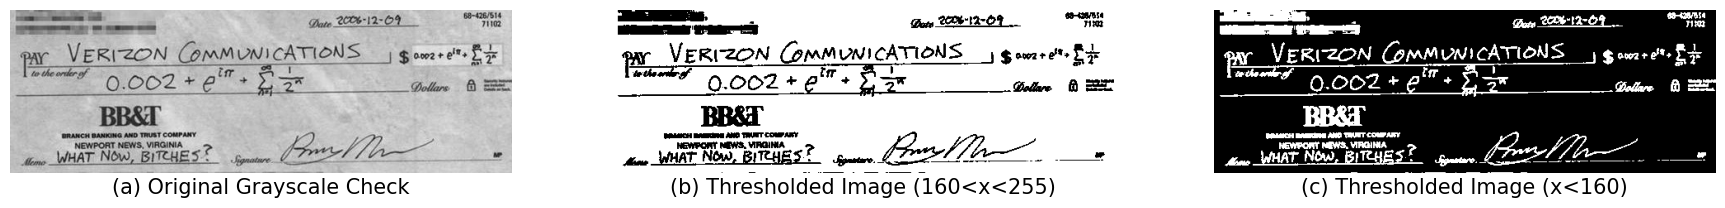

In [6]:
# The large peak of pixels at about ~200 grayscale value corresponds to the background which comprises most of the image
# We threshold the image to isolate the pixels assuming the grayscale values that comprise the text
I1 = (img<255) & (img>160)     # targets the pixels within the range of 160-255 grayscale value
I2 = (img<160)                 # targets the pixels below 160 grayscale value

# Juxtaposition of thresholded images
plt.figure(figsize=(22,15))
# Subplot for original image
plt.subplot(131)
plt.axis('off')
plt.title('(a) Original Grayscale Check', y=-0.18, fontsize=15)
plt.imshow(img, cmap='gray')
# Subplot for 160<img<255
plt.subplot(132)
plt.axis('off')
plt.title('(b) Thresholded Image (160<x<255)', y=-0.18, fontsize=15)
plt.imshow(I1, cmap='gray')
# Subplot for img<160
plt.subplot(133)
plt.axis('off')
plt.title('(c) Thresholded Image (x<160)', y=-0.18, fontsize=15)
plt.imshow(I2, cmap='gray')

plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/thresholded.png", dpi = 300, bbox_inches='tight')
plt.show()

## **Normalized Chromaticity Coordinates**

In [7]:
# Define a function that crops the ROI of any image
def crop(img,x1,y1,x2,y2):
    return img[x1:x2,y1:y2]

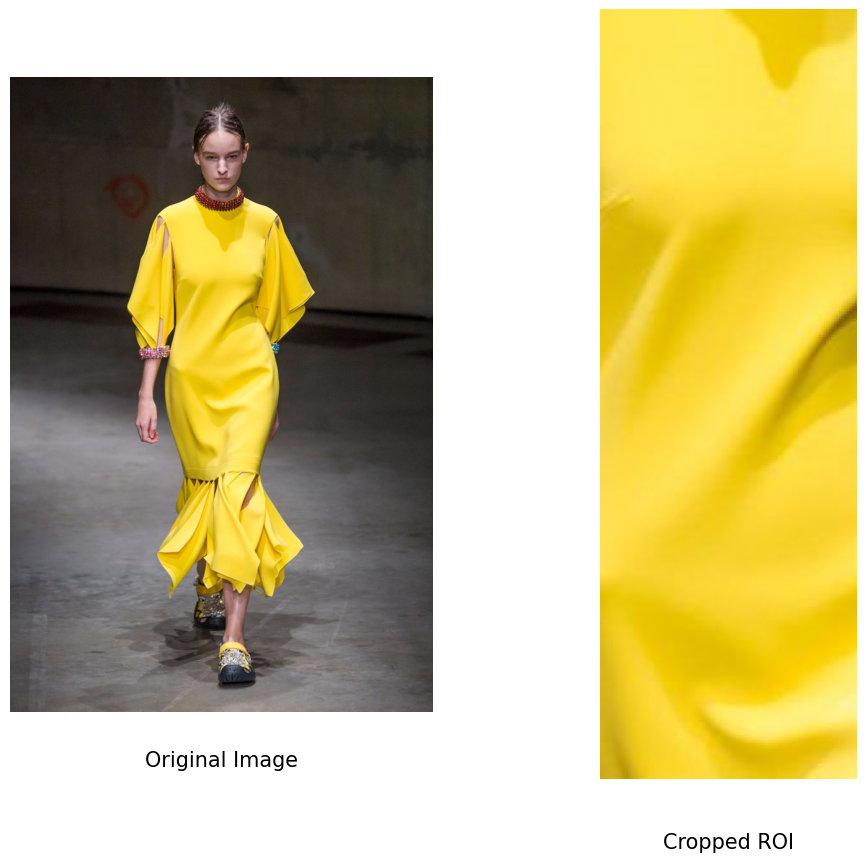

In [8]:
# Load in an image with large yellow areas
# We choose and crop a monochromatic ROI of the yellow dress
img = plt.imread('/Users/Amogus/Downloads/fashion.jpg')
img_crop = crop(img,250,275,550,375)

# Plot
plt.figure(figsize=(12,10))

# Subplot of image
plt.subplot(121)
plt.axis('off')
plt.title('Original Image', y=-0.10, fontsize=15)
plt.imshow(img)
# Subplot of cropped ROI
plt.subplot(122)
plt.axis('off')
plt.title('Cropped ROI', y=-0.10, fontsize=15)
plt.imshow(img_crop)

plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/image_and_cropped.png", dpi = 300, bbox_inches='tight')
plt.show()

In [10]:
# Define a function that solves for the normalized chromaticity coordinates of a given image
def NCC(img):
    # Convert uint8 data types to float
    img = img.astype(float)
    # Separate each color channel of the image
    R_channel = img[:,:,0]
    G_channel = img[:,:,1]
    B_channel = img[:,:,2]
    # Brightness array
    I = R_channel + G_channel + B_channel
    # Set zero elements to a large number to avoid division by zero
    I[I == 0] = 1000000000
    # Normalize each color channel by the brightness array
    r = R_channel / I
    g = G_channel / I
    b = 1 - r - g
    # Flatten out the blue channel
    b_flat = 1 - r.flatten() - g.flatten()
    # Set negative elements to zero
    b_flat[b_flat<0] = 0
    
    return r, g, b_flat

# Apply NCC function to original image
NCC_img = NCC(img)
# Apply NCC function to ROI
NCC_crop = NCC(img_crop)

# Combine all iterables into a list
NCC_img_channels = list(zip(NCC_img[0].flatten(),NCC_img[1].flatten(),NCC_img[2]))
NCC_crop_channels = list(zip(NCC_crop[0].flatten(),NCC_crop[1].flatten(),NCC_crop[2]))

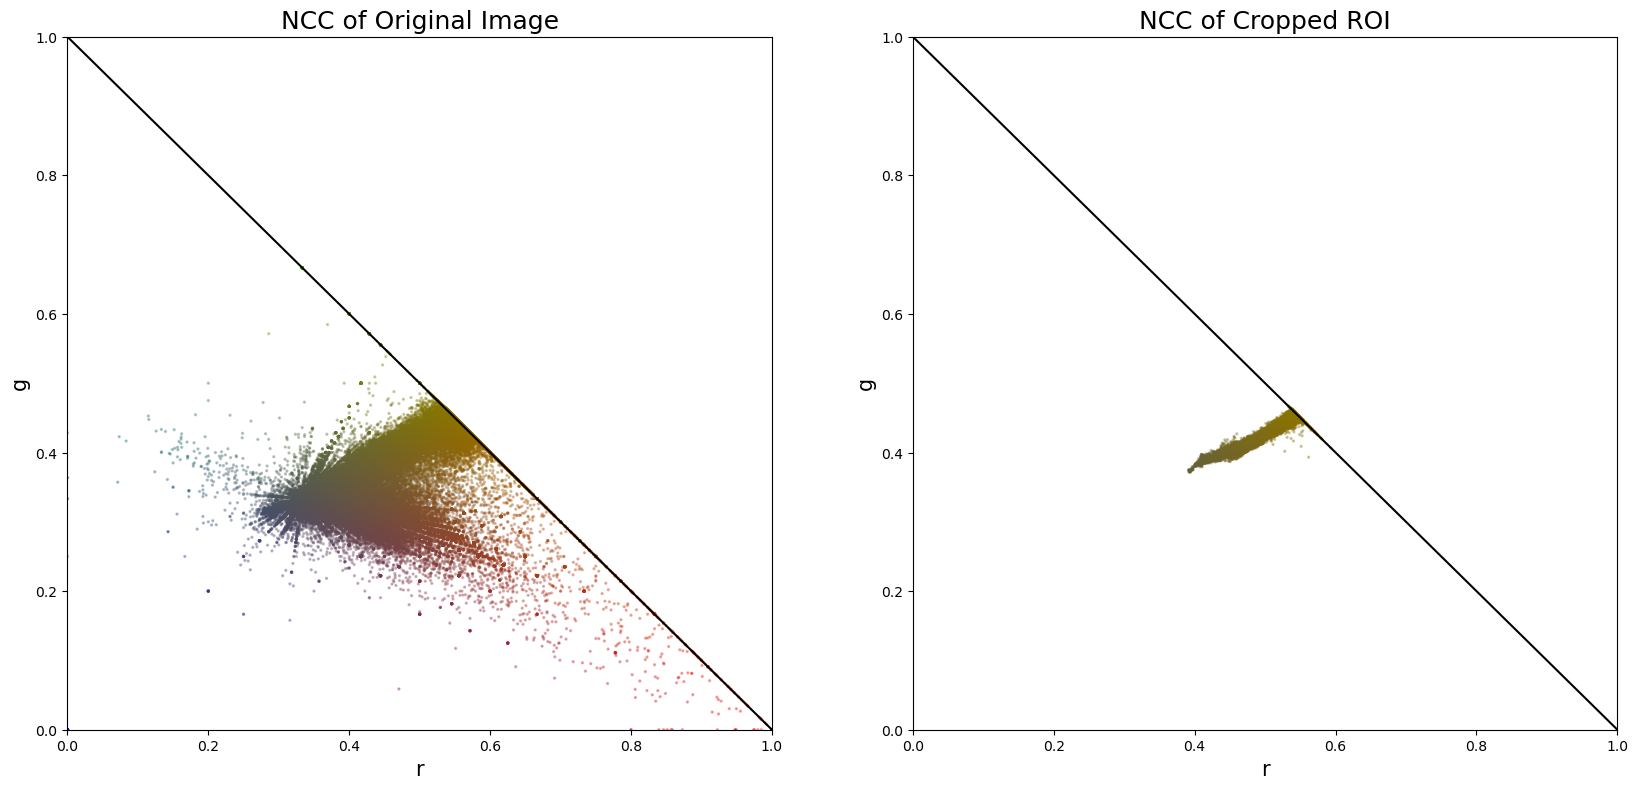

In [11]:
# Plot separation line of the NCC which is essentially just a negative linear function
x = np.linspace(0,1,100)
y = 1-x

# Plot parameters
plt.figure(figsize=(20,9))
# First subplot for the NCC of the original image
plt.subplot(121)
plt.plot(x,y, color='black')     # plot for negative linear function
plt.scatter(NCC_img[0].flatten(),NCC_img[1].flatten(), s = 2, alpha=0.3, color = NCC_img_channels)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('r', fontsize=15)
plt.ylabel('g', fontsize=15)
plt.title('NCC of Original Image', fontsize=18)

# Second subplot for the NCC of the ROI
plt.subplot(122)
plt.scatter(NCC_crop[0].flatten(),NCC_crop[1].flatten(), s = 2, alpha=0.3, color = NCC_crop_channels)
plt.plot(x,y, color='black')     # plot for negative linear function
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('r', fontsize=15)
plt.ylabel('g', fontsize=15)
plt.title('NCC of Cropped ROI', fontsize=18)

plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/NCC_image_ROI.png", dpi = 300, bbox_inches='tight')
plt.show()

# **Parametric Segmentation**

In [12]:
# Define function that solves for the gaussian PDF given an image and its ROI
def gauss_PDF(img, ROI):
    mu = np.mean(ROI)              
    sigma_squared = (np.std(ROI))**2
    # gaussian PDF formula
    gauss_1 = (1 / np.sqrt(2*(sigma_squared)*np.pi))
    gauss_2 = np.exp(-(img - mu)**2 / (2*(sigma_squared)))
    
    return gauss_1*gauss_2

# Apply function on the rg chromaticity coordinates
gauss_r = gauss_PDF(NCC_img[0], NCC_crop[0])
gauss_g = gauss_PDF(NCC_img[1], NCC_crop[1])
# Take product for joint probability
parametric = gauss_r * gauss_g

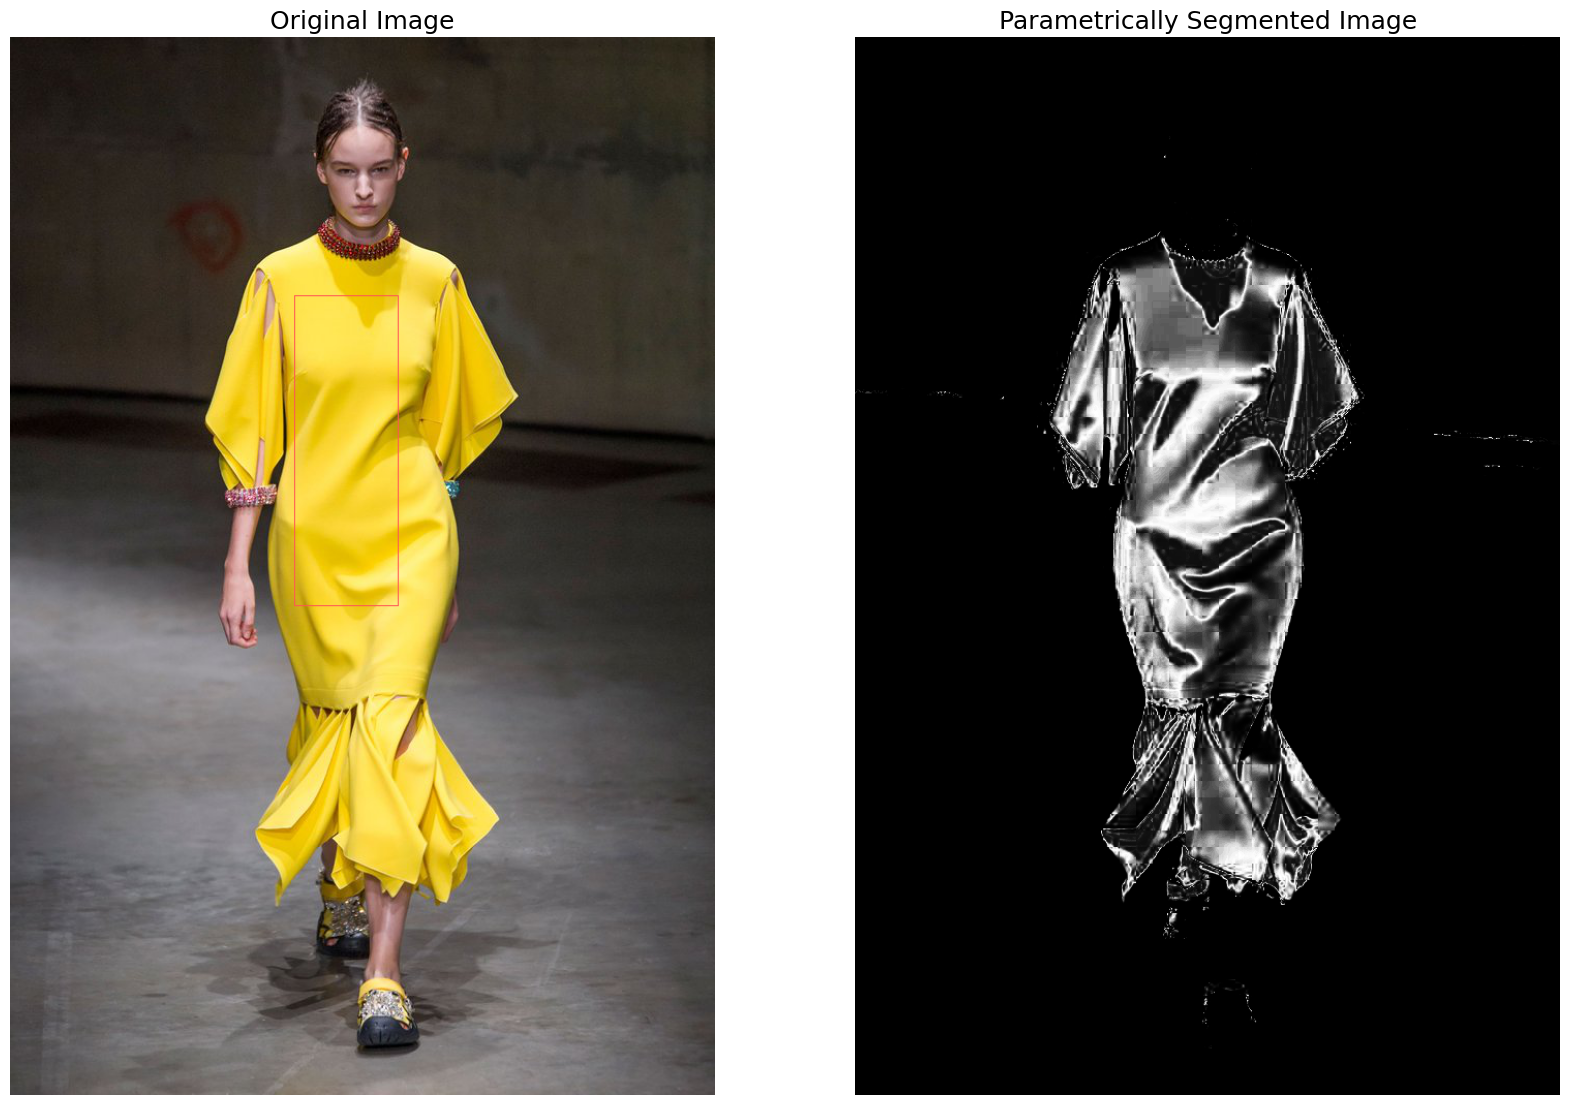

In [13]:
# Highlight the ROI
ROI_rect = np.copy(img)
a = cv2.rectangle(ROI_rect,(275,250),(375,550),(255,85,85),1)
# Plot parameters
plt.figure(figsize=(20,20))

# First subplot for original image
plt.subplot(121)
plt.imshow(a)
plt.axis('off')
plt.title('Original Image', fontsize=18)

# Second subplot for parametric segmentation result
plt.subplot(122)
plt.imshow(parametric, cmap='gray')
plt.axis('off')
plt.title('Parametrically Segmented Image', fontsize=18)

plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/parametric_yellow_dress.png", dpi = 300, bbox_inches='tight')
plt.show()

# **Non-parametric segmentation**

In [14]:
# To make our lives easier, we use openCV packages specifically cv2 to automate most of the things I already did previously
def nonparametric(image,x1,x2,y1,y2,bin_size):
    img = cv2.imread(image)
    # Since cv2 reads the image in BGR, we revert it back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # For even more convenience, we convert the image to hsv and isolate the hue channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hue = hsv[:, :, 0]

    # Defining the ROI
    roi = np.zeros_like(img)                # Initialize roi array with zeros
    roi[x1:x2, y1:y2, :] = [255, 85, 85]    # border color

    # Calculate the histogram of the hue channel 
    hist = cv2.calcHist([hue], [0], roi[:, :, 1], [bin_size], [0, bin_size])
    # Normalize the histogram
    cv2.normalize(hist, hist, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    # Backproject the histogram using the hue channel
    backproj = cv2.calcBackProject([hue], [0], hist, [0, 180], scale=1)
    
    # Isolate the pixels that match the patch
    mask = backproj > 1
    red = img[:,:,0]*mask
    green = img[:,:,1]*mask
    blue = img[:,:,2]*mask
    nonparam = np.dstack((blue,green,red))
    nonparam = cv2.cvtColor(nonparam, cv2.COLOR_BGR2RGB)    # Convert back to RGB
    
    # Draw a rectangle to highlight the ROI in the image
    original_img = img.copy()            
    original_img = cv2.rectangle(original_img, (y1, x1), (y2, x2), (255,255,255), 2)
    
    # Plot parameters
    fig, axs = plt.subplots(1, 2, figsize=(17, 12))

    # First subplot for original image with highlighted ROI
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    # Second subplot for nonparametrically segmented image
    axs[1].imshow(nonparam)
    axs[1].set_title(f'Non-Parametrically Segmented Image (bin size = {bin_size} )')
    axs[1].axis('off')

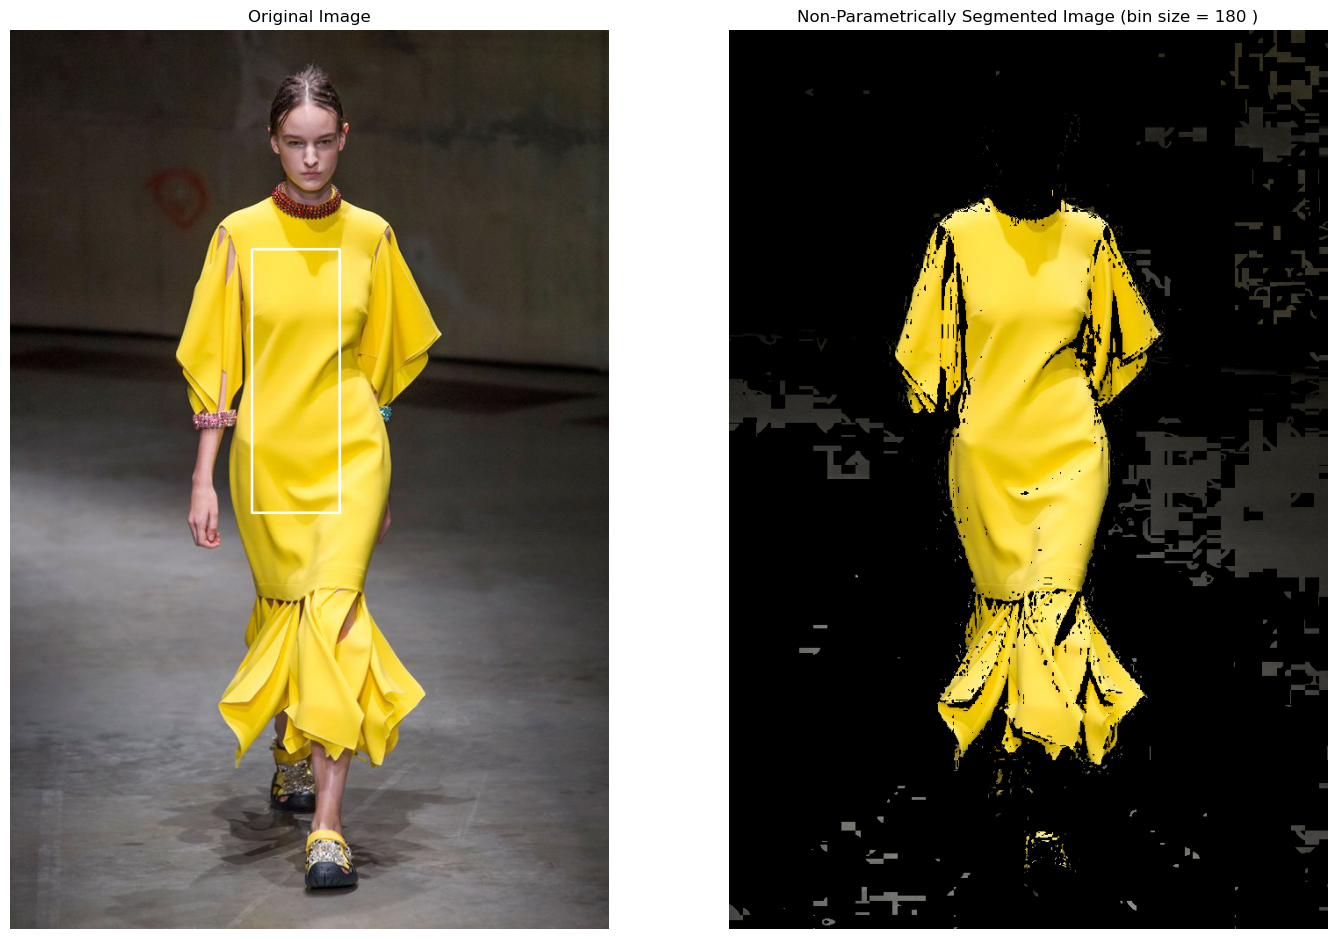

In [15]:
nonparametric('/Users/Amogus/Downloads/fashion.jpg',250,550,275,375,180)
plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/nonparametric_yellow_dress.png", dpi = 300, bbox_inches='tight')

## **Extra Demonstrations**

In [17]:
flower = plt.imread("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/flower.png")

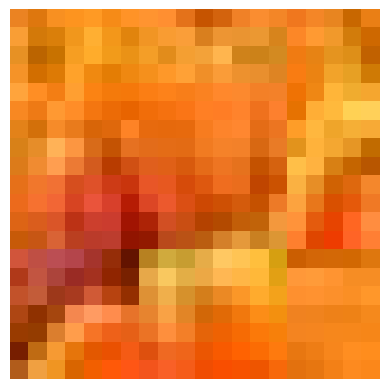

In [18]:
flower_crop_orange = crop(flower, 675,625,695,645)
plt.imshow(flower_crop_orange)
plt.axis('off')
plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/orange_tulip_ROI.png", dpi = 300, bbox_inches='tight')

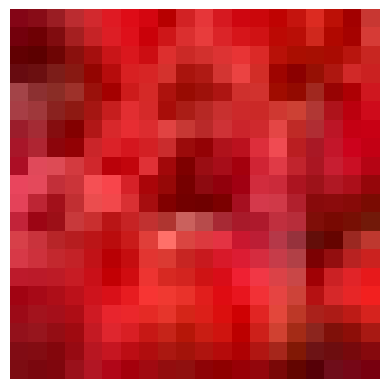

In [20]:
flower_crop_red = crop(flower, 580,480,600,500)
plt.imshow(flower_crop_red)
plt.axis('off')
plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/red_tulip_ROI.png", dpi = 300, bbox_inches='tight')

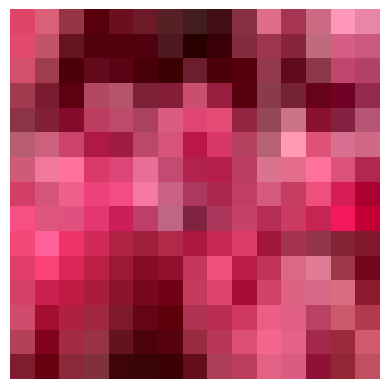

In [21]:
flower_crop_pink = crop(flower, 375,675,390,690)
plt.imshow(flower_crop_pink)
plt.axis('off')
plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/pink_tulip_ROI.png", dpi = 300, bbox_inches='tight')

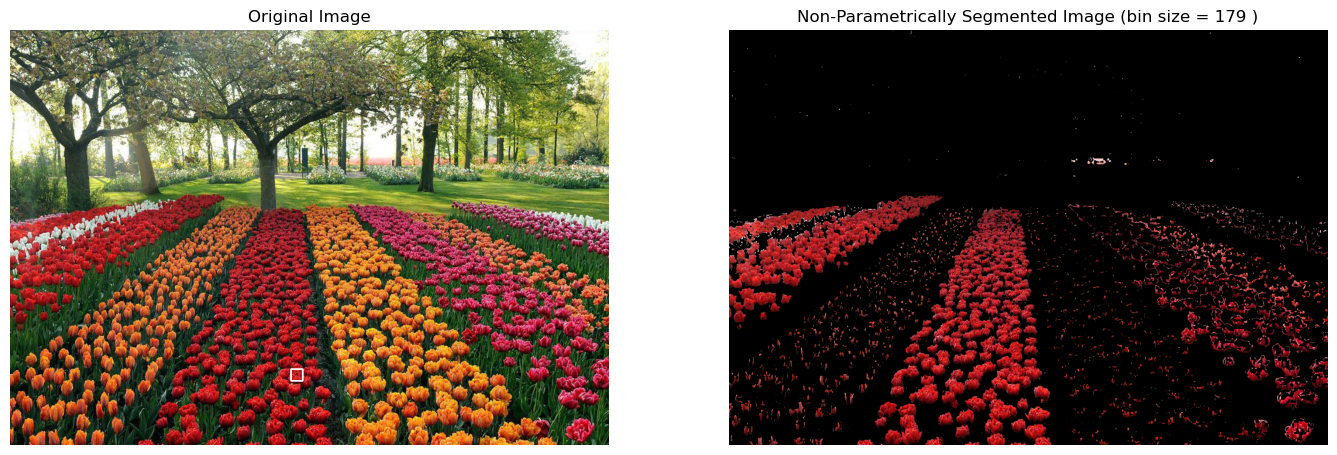

In [22]:
# ROI = red tulips
nonparametric('/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/flower.png',580,600,480,500,179)
plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/nonparametric_red_tulips.png", dpi = 300, bbox_inches='tight')

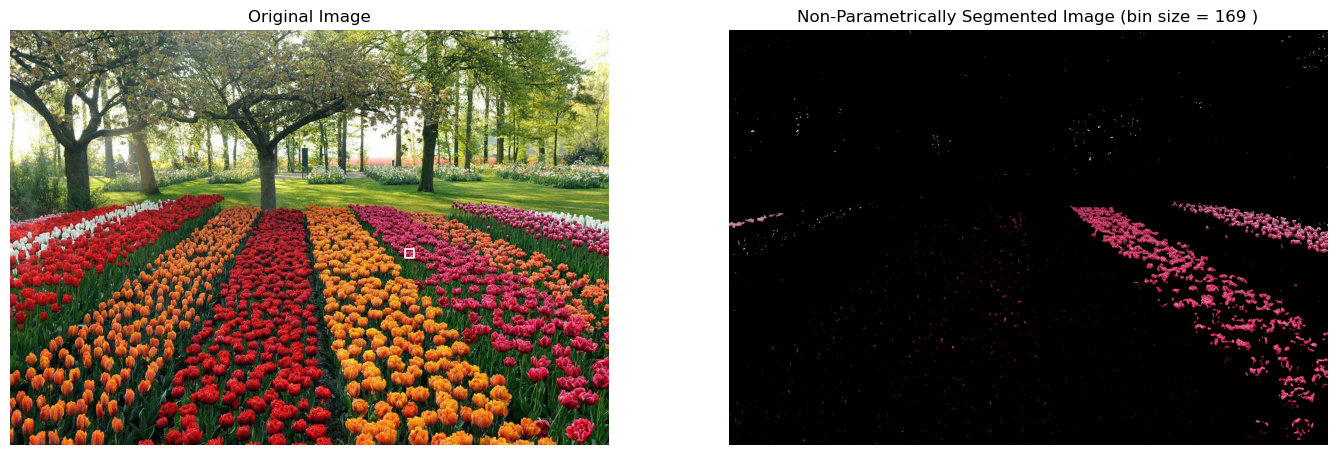

In [23]:
# ROI = pink tulips
nonparametric('/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/flower.png',375,390,675,690,169)
plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/nonparametric_pink_tulips.png", dpi = 300, bbox_inches='tight')

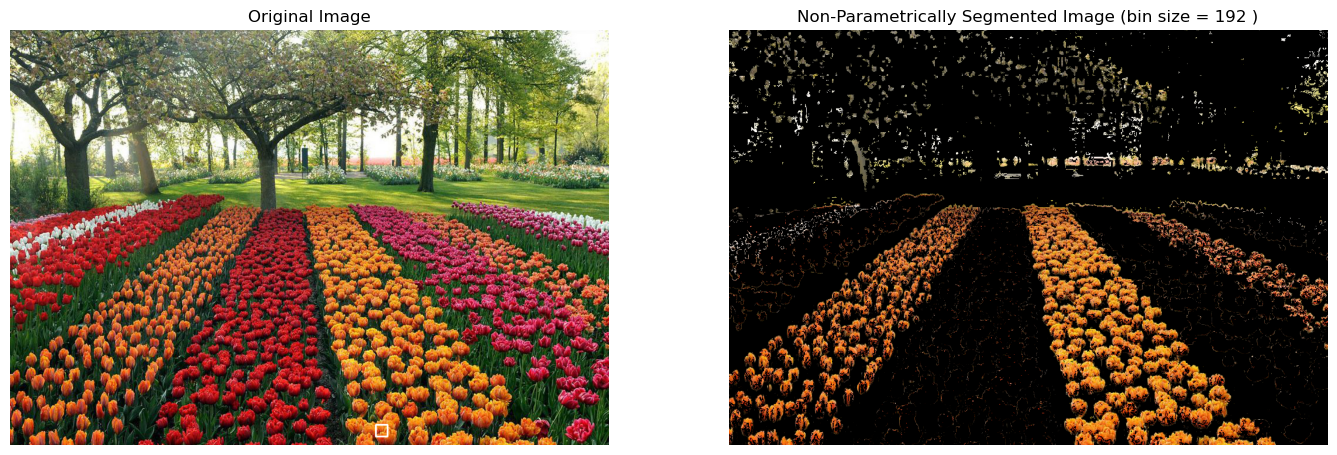

In [24]:
# ROI = orange tulips
nonparametric('/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/flower.png',675,695,625,645,192)
plt.savefig("/Users/Amogus/Desktop/2nd Semester (2022-2023)/App Physics 157/ACT5/nonparametric_orange_tulips.png", dpi = 300, bbox_inches='tight')